In [21]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scalecast.Forecaster import Forecaster 
from scalecast.Pipeline import Transformer,Reverter,Pipeline 
from scalecast.util import (
    find_optimal_transformation, 
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from scalecast import GridGenerator 
from tensorflow.keras.callbacks import EarlyStopping 
import pandas_datareader as pdr 

In [22]:
# pip install scalecast

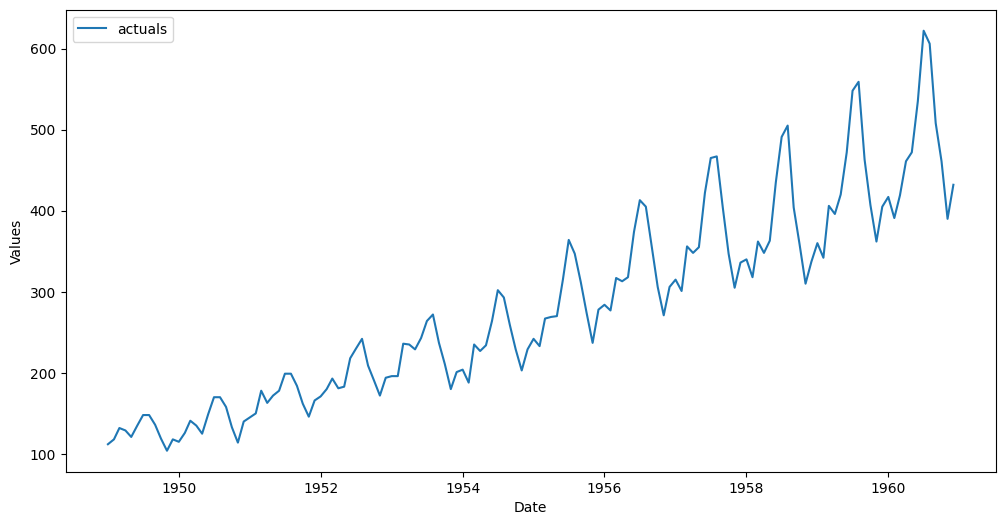

In [23]:
data = pd.read_csv("AirPassengers.csv",parse_dates=['Month']) 
f = Forecaster(
    y = data['#Passengers'],
    current_dates = data['Month'],
    future_dates=24,
)
f.plot() 
plt.show()

In [24]:
def forecaster(f):
    f.set_estimator('rnn') 
    f.manual_forecast(
        lags=18,
        layers_struct = [
            ('LSTM',{'units':36,'activation':'tanh'}),
        ],
        epochs = 200,
        call_me = 'lstm'
    )
transformer = Transformer(
    transformers=[
        ('DetrendTransform',{'poly_order':2}),
        'DeseasonTransform',
    ]
)
reverter = Reverter(
    reverters = [
        'DeseasonRevert',
        'DetrendRevert',
    ],
    base_transformer=transformer
)
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [25]:
f = pipeline.fit_predict(f)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3639
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3392 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3199
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2925
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2606 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2263
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.2032
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.1898
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1723 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1579
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1497
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1422 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1410 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1391
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1359
Epoch 16/200
4/4

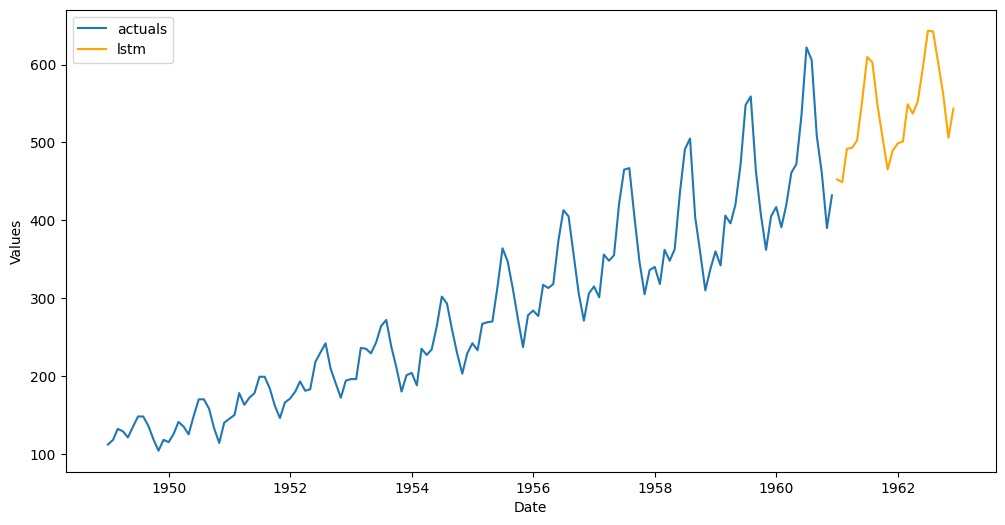

In [26]:
f.plot()
plt.savefig('LSTM Univariate.png') 
plt.show()

In [27]:
data = pd.read_csv("audioer.csv")

In [28]:
vol = data.groupby('Date')['Total Volume'].sum() 
price = data.groupby('Date')['AveragePrice'].sum() 
fvol = Forecaster(
    y = vol,
    current_dates = vol.index,
    test_length=13,
    validation_length=13,
    future_dates=13,
    metrics=['rmse','r2'],
)
fprice = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
)

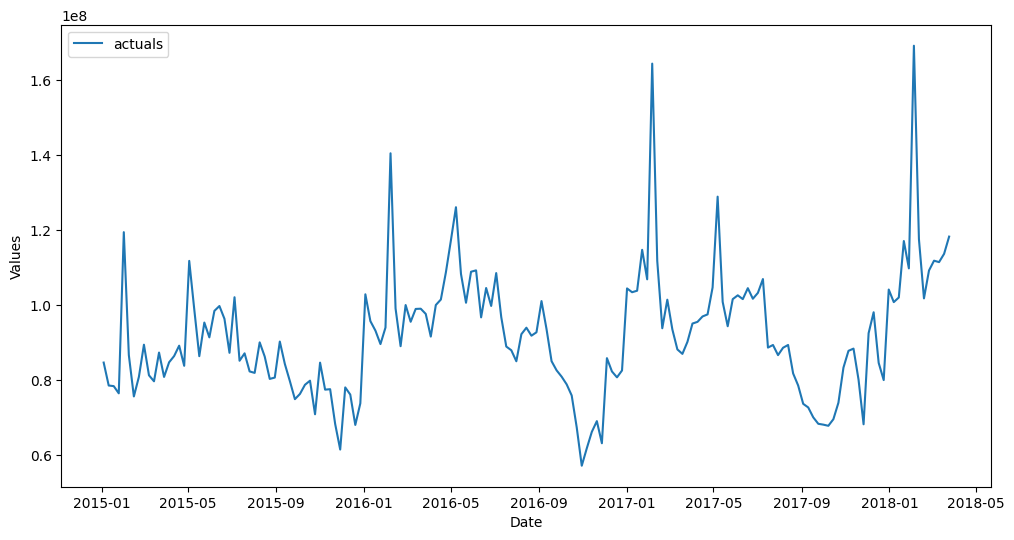

In [29]:
fvol.plot()  
plt.show()

In [30]:
transformer,reverter = find_optimal_transformation(
    fvol,
    set_aside_test_set=True,
    return_train_only=True,
    verbose=True,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
    m = 52,
    test_length=4
)

Using mlr model to find the best transformation set on 1 test sets, each 4 in length.
All transformation tries will be evaluated with 52 lags.
Last transformer tried:
[]
Score (rmse): 10788435.47849977
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 17367936.069693524
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 12269036.469923085
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'ln_trend': True})]
Score (rmse): 12093617.597284125
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (rmse): 9289548.042079167
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', BoxcoxTransform, {'lmbda': -0.5})]
Score (rmse): 10

In [31]:
fprice = transformer.fit_transform(fprice) 
fvol = transformer.fit_transform(fvol)

In [32]:
rnn_grid = gen_rnn_grid(
    layer_tries = 10,
    min_layer_size = 3,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [33]:
def forecaster(fvol,fprice):
    fvol.set_estimator('naive') 
    fvol.manual_forecast() 
    fvol.add_ar_terms(13) 
    fvol.set_estimator('rnn')
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_univariate')
    # multivariate lstm model
    fvol.add_series(fprice.y,called='price')
    fvol.add_lagged_terms('price',lags=13,drop=True)
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_multivariate')

In [34]:
forecaster(fvol=fvol,fprice=fprice)

c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1624: Warning: The last CV fold will not be considered when choosing hyperparemeters for the rnn model, as all parameters failed to return a metric. This most frequently happens when default CV parameters were used with an RNN model.
  warnings.warn(
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1633: Warning: None of the keyword/value combos stored in the grid could be evaluated for the rnn model. See the errors in warnings.log.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step   


c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1624: Warning: The last CV fold will not be considered when choosing hyperparemeters for the rnn model, as all parameters failed to return a metric. This most frequently happens when default CV parameters were used with an RNN model.
  warnings.warn(
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1633: Warning: None of the keyword/value combos stored in the grid could be evaluated for the rnn model. See the errors in warnings.log.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [35]:
fvol = reverter.fit_transform(fvol)

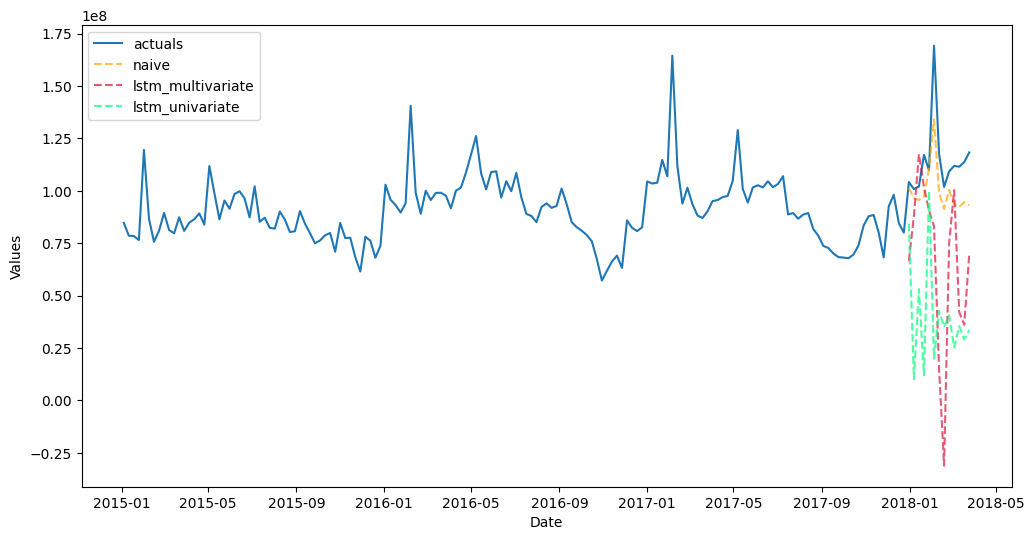

In [36]:
fvol.plot_test_set(order_by='TestSetRMSE') 
plt.savefig('LSTM MV test results.png') 
plt.show()

In [37]:
pd.options.display.float_format = '{:,.4f}'.format 
summ = fvol.export('model_summaries',determine_best_by='TestSetRMSE') 
summ[['ModelNickname','TestSetRMSE','TestSetR2']]

,ModelNickname,TestSetRMSE,TestSetR2
0,naive,"17,403,456.6059",-0.0646
1,lstm_multivariate,"63,562,036.9813",-13.2005
2,lstm_univariate,"81,725,797.1604",-22.4762


In [38]:
summ[['ModelNickname','HyperParams']].style.set_properties(height = 5)

,ModelNickname,HyperParams
0,naive,{}
1,lstm_multivariate,{}
2,lstm_univariate,{}


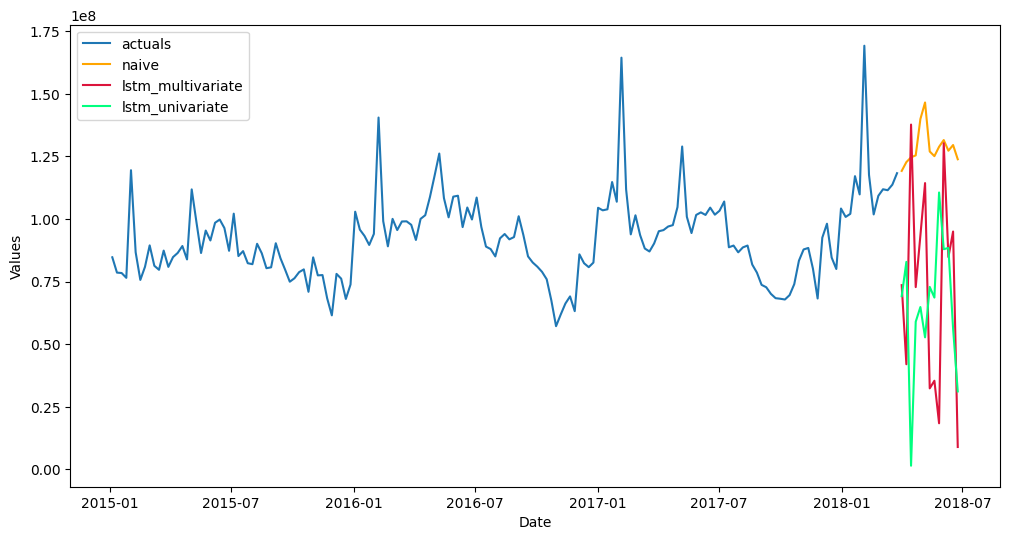

In [39]:
fvol.plot(order_by='TestSetRMSE') 
plt.show() 

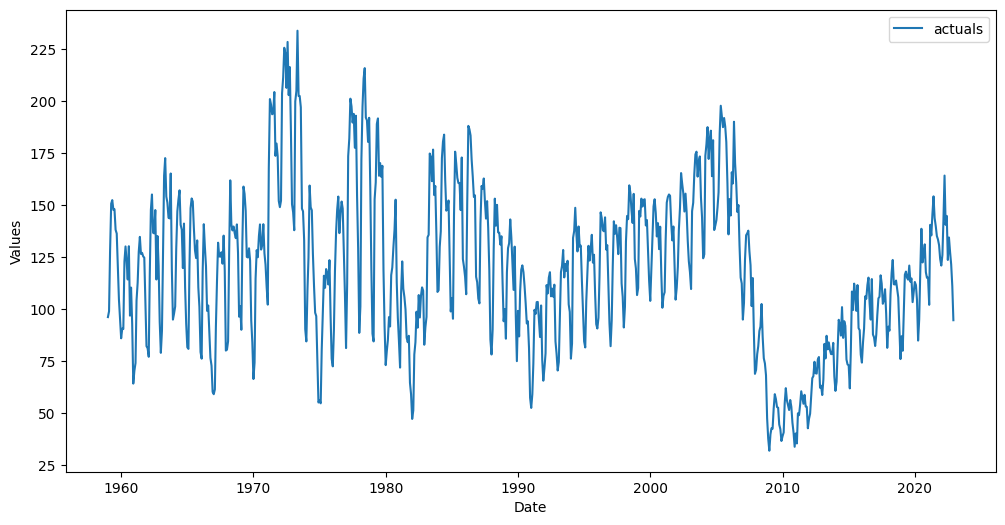

In [40]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2022-12-31',
)

f = Forecaster(
    y = df['HOUSTNSA'],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
    test_length = .1, # 10% test length
    cis = True,
    cilevel = .9, # 90% intervals
)

f.plot()
plt.show()

In [41]:
transformer,reverter = find_optimal_transformation(
    f,
    estimator='lstm',
    epochs=10,
    set_aside_test_set=True,
    return_train_only=True,
    verbose=True,
    m = 52,
    test_length=24,
    num_test_sets=3,
    space_between_sets=12,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ]
)

Using lstm model to find the best transformation set on 3 test sets, each 24 in length.
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4318
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4093 
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3849 
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3551 
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3295 
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2975  
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2584
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2244
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1991 
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1753
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.4400
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4135
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3789
Epoch 4/10
21/21

In [42]:
rnn_grid = gen_rnn_grid(
    layer_tries=100,
    min_layer_size = 1,
    max_layer_size=5,
    units_pool=[100],
    epochs=[100],
    dropout_pool=[0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
        monitor='val_loss',
        patience=3,
    ),
    random_seed=20,
)

In [43]:
def forecaster(f,grid):
    f.auto_Xvar_select(
        try_trend=False,
        try_seasonalities=False,
        max_ar=100
    )
    f.set_estimator('rnn')
    f.ingest_grid(grid)
    f.limit_grid_size(10) # randomly reduce the big grid to 10
    f.cross_validate(k=3,test_length=24) # three-fold cross-validation
    f.auto_forecast()

In [44]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f,grid=rnn_grid)

c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1624: Warning: The last CV fold will not be considered when choosing hyperparemeters for the rnn model, as all parameters failed to return a metric. This most frequently happens when default CV parameters were used with an RNN model.
  warnings.warn(
c:\Users\石天辰\.conda\envs\pytorch\lib\site-packages\scalecast\_Forecaster_parent.py:1633: Warning: None of the keyword/value combos stored in the grid could be evaluated for the rnn model. See the errors in warnings.log.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


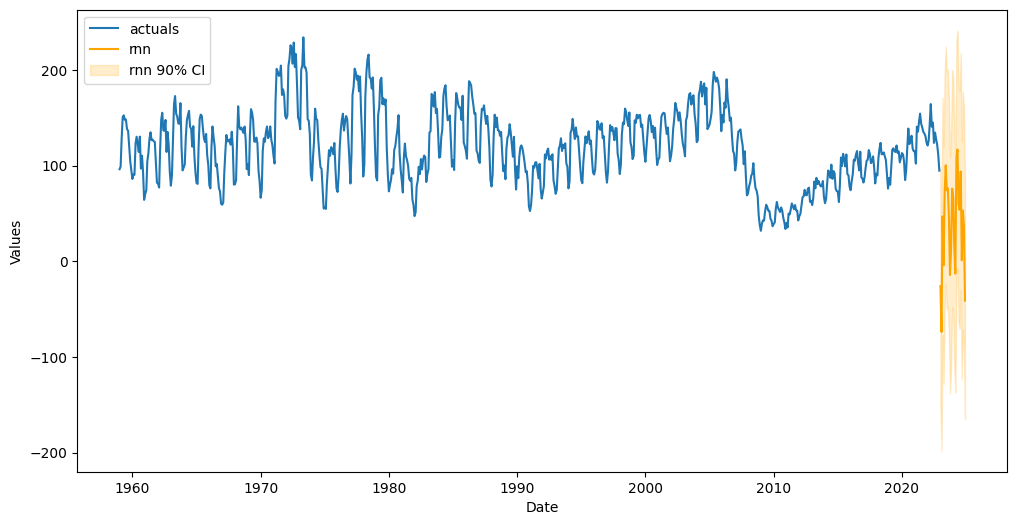

In [45]:
f.plot(ci=True)
plt.savefig('Probabilistic LSTM.png')
plt.show()

In [46]:
params = f.best_params 
num_chosen_lags = len(f.get_regressor_names()) 

In [47]:
def forecaster(f,params):
    f.set_estimator('rnn') 
    f.manual_forecast(**params,test_again=False,lags=num_chosen_lags) 
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
) 

In [48]:
params = f.best_params
num_chosen_lags = len(f.get_regressor_names())

In [49]:
def forecaster(f,params):
    f.set_estimator('rnn')
    f.manual_forecast(**params,test_again=False,lags=num_chosen_lags)

In [50]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [51]:
f = pipeline.fit_predict(f,params = params)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [52]:
backtest_results = backtest_for_resid_matrix(
    f,
    pipeline=pipeline,
    alpha = .1,
    jump_back = 12,
    params = f.best_params,
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.4886
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.3417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 0.4413
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.5929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.4109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.5370 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4824
1/1 ━━━━━━━━━

In [53]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

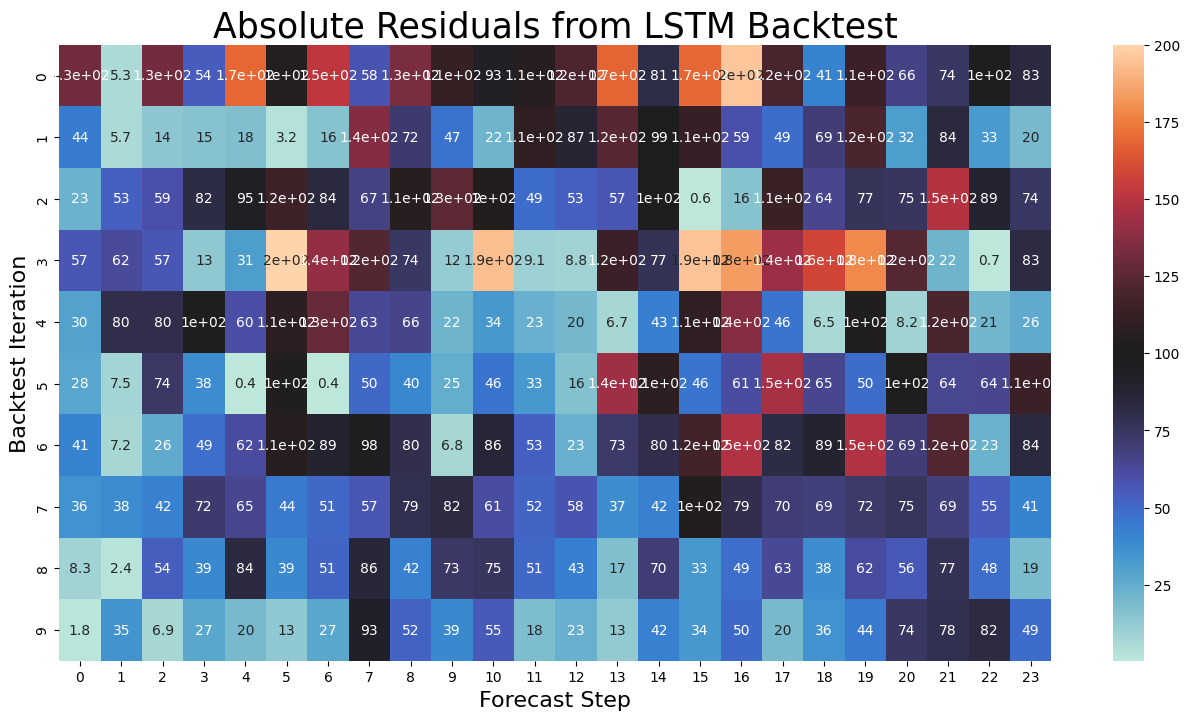

In [54]:
pd.options.display.max_columns = None
fig, ax = plt.subplots(figsize=(16,8))
mat = pd.DataFrame(np.abs(backtest_resid_matrix[0]['rnn']))
sns.heatmap(
    mat.round(1),
    annot = True,
    ax = ax,
    cmap = sns.color_palette("icefire", as_cmap=True),
)
plt.ylabel('Backtest Iteration',size=16)
plt.xlabel('Forecast Step',size = 16)
plt.title('Absolute Residuals from LSTM Backtest',size=25)
plt.savefig('LSTM Resid Matrix.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.heatmap(
    pd.DataFrame({'Mean Residuals':mat.mean().round(1)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[0],
    annot_kws={"fontsize": 16},
)
cbar = ax[0].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[0].set_title('Mean Absolute Residuals',size=20)
ax[0].set_ylabel('Forecast Step',size=15)
ax[0].set_xlabel('')
sns.heatmap(
    pd.DataFrame({'Residuals 95 Percentile':np.percentile(mat, q=95, axis = 0)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[1],
    annot_kws={"fontsize": 16},
)
cbar = ax[1].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[1].set_title('Absolute Residual 95 Percentiles',size=20)
ax[1].set_ylabel('Forecast Step',size=15)
ax[1].set_xlabel('')
plt.show()

In [ ]:
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix,alpha=.1)
f.plot(ci=True)
plt.savefig('LSTM dynamic intervals.png')
plt.show()

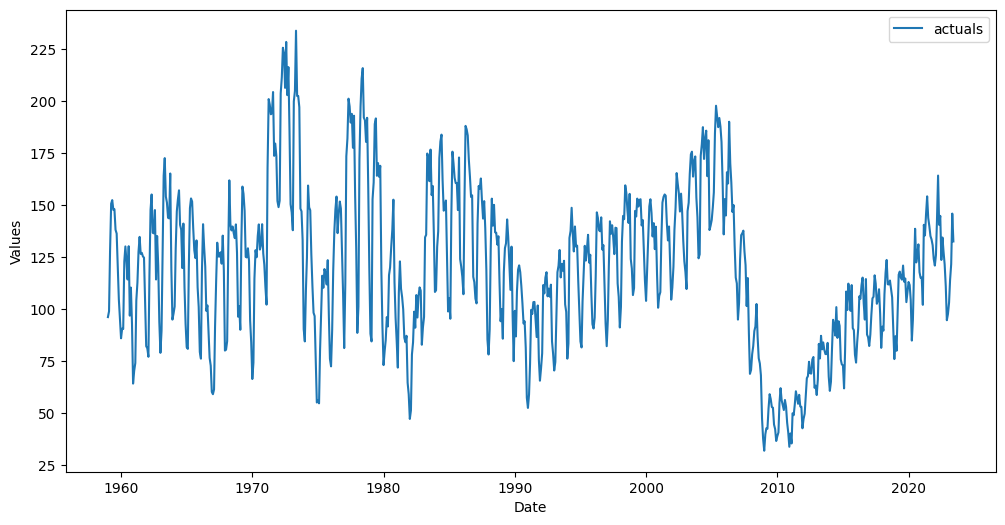

In [55]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [56]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [57]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


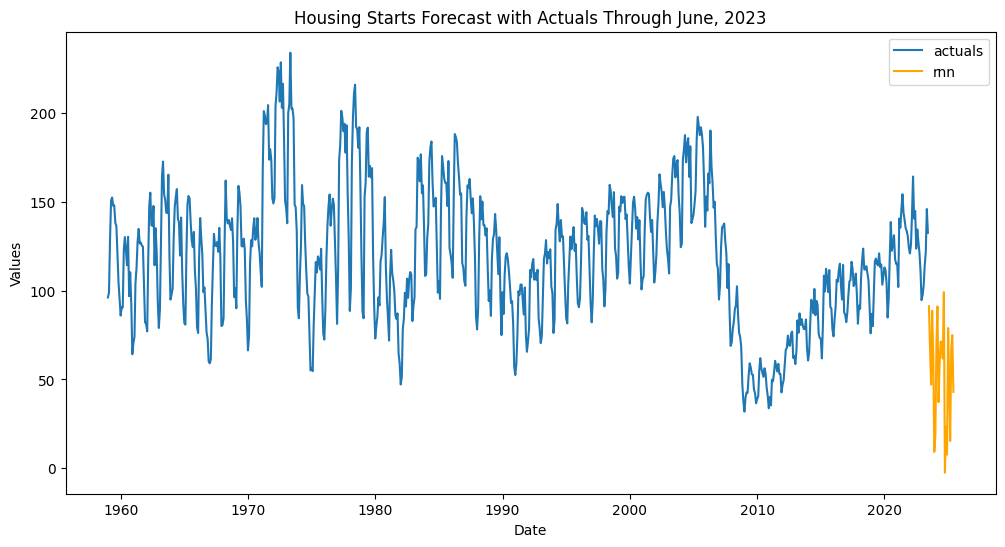

In [58]:
f_new.plot()
plt.title('Housing Starts Forecast with Actuals Through June, 2023')
plt.savefig('RNN transferred same series.png')
plt.show()

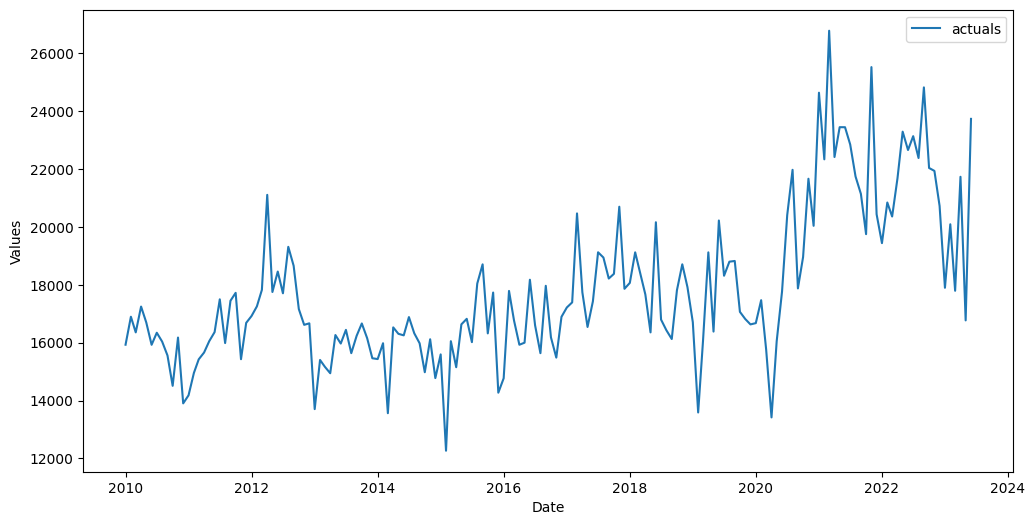

In [59]:
df = pdr.get_data_fred(
    'CANWSCNDW01STSAM',
    start = '2010-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [60]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [61]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


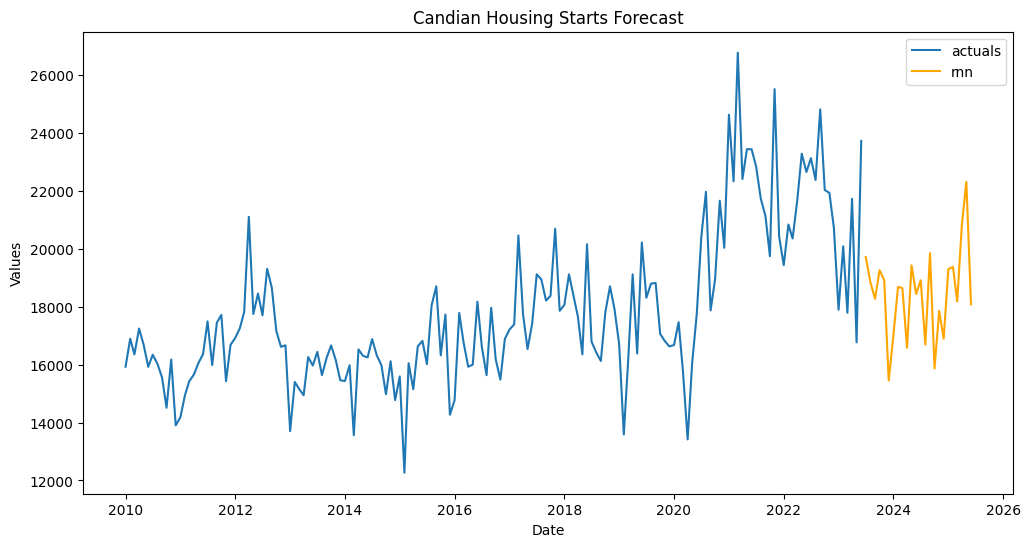

In [62]:
f_new.plot()
plt.title('Candian Housing Starts Forecast')
plt.savefig('Transferred RNN Canada')
plt.show()